# Assignment on Facial Expression Recognition with CNN
The task in this assignment is to train a convolutional neural network that can recognize the facial expression from an image.

## Dataset
You will use the FER2013 dataset. The dataset is available in `torchvision`. For more details, see [here](https://pytorch.org/vision/main/generated/torchvision.datasets.FER2013.html#torchvision.datasets.FER2013).

## Architectures
In this assignment, you will experiment with the following architectures.
* Alexnet
* VGG11
* Resnet18
* Inception V3

Make necessary adjustments to the architecture to adapt it for you classification task. Do not use pre-trained weights.

## Training
* Train each model for several epochs
* Track the training loss and training accuracies as well as the testing loss and testing accuracies at each epoch (Note: This is only for simplicity. We typically do not use test set during the training).
*  Tune batch size and learning rates hyper-parameters. Experiment with at least 3 values of the hyper-parameter.

## Submission Guidelines
* Plot the training loss and test loss separately for each configuration (architecture, batch size, learning rate).
* Comment on the learning curves.
* Submit the following by 21 February, 2025
    * A PDF containing the learning curves and the discussions.
    * A `zip` file containing your codes.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

import spacy
from nltk.corpus import stopwords


In [2]:
batch_size = 32

In [3]:
transform = T.Compose([
    T.Resize((64, 64)),  
    T.ToTensor(),         
    T.Normalize([0.5], [0.5])  ])
data_location_train =  '../input/fer2013/train/'
data_location_test =  '../input/fer2013/test/'

train_dataset = datasets.ImageFolder(root=data_location_train, transform=transform)
test_dataset = datasets.ImageFolder(root=data_location_test, transform=transform)


train_data_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


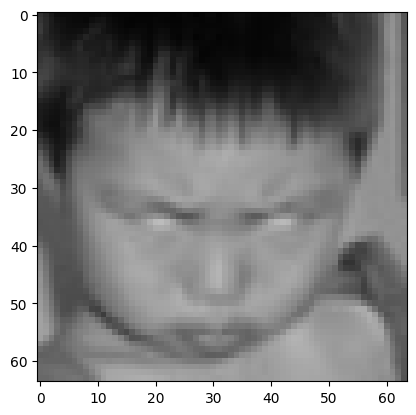

angry


In [9]:
print("Classes:", train_dataset.classes) 
def imshow(img):
    img = img / 2 + 0.5      
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_data_loader)
images, labels = next(dataiter)
imshow(images[0])
print(train_dataset.classes[labels[0]])

In [10]:
alexnet = models.alexnet(weights=None)

The following function will return train and test data loaders with a given batch size.

In [21]:
def get_data_loaders(batch_size):
    pass

The following function will return an instance of the model that will be trained. Here `name` will be one of the following, `["alexnet", "vgg11", "resnet", "inception"]`.

In [22]:
def get_model(name):
    pass

The following functions will return the training criterion and optimizer respectively.

In [23]:
def get_criterion():
    criterion = nn.CrossEntropyLoss()


def get_optimizer(learning_rate):
    optimizer = optim.Adam(alexnet.parameters(), lr=learning_rate)

The following function will train the model using the train loader and assess its performance on both the train and test data.

In [24]:
def train(model, train_loader, val_loader, num_epochs, optimizer, criterion):
    pass

The following function will plot the training and test loss/accuracy vs epoch. You can use the `what` and `title` parameters to detect which learning curve is being plot. If you want, you can also save the plots for furture use.

In [25]:
def plot(train_acc, test_acc, what, title):
    pass

In [26]:
batch_sizes = []
learning_rates = []
names = []
# modify the value in the following statement
num_epocs = 0
for bs in batch_sizes:
    for lr in learning_rates:
        for name in names:
            train_loader, test_loader = get_data_loader(bs)
            model = get_model(name)
            optimizer = get_optimizer(lr)
            criterion = get_criterion()

            train_accs, train_loss, test_acc, test_loss = train(
                model, train_loader, test_loader, num_epocs, optimizer, criterion)

            plot(train_acc, test_acc, what='acc', title=f'{name}_{bs}_{lr}_{"acc"}')
            plot(train_loss, test_loss, what='loss', title=f'{name}_{bs}_{lr}_{"loss"}')